# Predicting Boston Housing Prices

This project was completed as part of the Machine Learning Engineer Nanodegree program from Udacity.

In this project, we will evaluate the performance and predictive power of a model that has been trained and tested on data collected from homes in suburbs of Boston, Massachusetts. A model trained on this data that is seen as a *good fit* could then be used to make certain predictions about a home — in particular, its monetary value. This model would prove to be invaluable for someone like a real estate agent who could make use of such information on a daily basis.

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Housing). The Boston housing data was collected in 1978 and each of the 506 entries represent aggregated data about 14 features for homes from various suburbs in Boston, Massachusetts.

For the purposes of this project, the following preprocessing steps have been made to the dataset:
- 16 data points have an `'MEDV'` value of 50.0. These data points likely contain **missing or censored values** and have been removed.
- 1 data point has an `'RM'` value of 8.78. This data point can be considered an **outlier** and has been removed.
- The features `'RM'`, `'LSTAT'`, `'PTRATIO'`, and `'MEDV'` are essential. The remaining **non-relevant features** have been excluded.
- The feature `'MEDV'` has been **multiplicatively scaled** to account for 35 years of market inflation.

In [2]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from sklearn.cross_validation import ShuffleSplit

# Import supplementary visualizations code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Boston housing dataset
data = pd.read_csv('housing.csv')
prices = data['MEDV']
features = data.drop('MEDV', axis = 1)
    
# Success
print "Boston housing dataset has {} data points with {} variables each.".format(*data.shape)

/home/akshaya/py2_kernel/local/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Boston housing dataset has 489 data points with 4 variables each.


/home/akshaya/py2_kernel/local/lib/python2.7/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


## Data Exploration
In this section of this project, we will make a cursory investigation about the Boston housing data. 

Since the main goal of this project is to construct a working model which has the capability of predicting the value of houses, we will need to separate the dataset into **features** and the **target variable**. The **features**, `'RM'`, `'LSTAT'`, and `'PTRATIO'`, give us quantitative information about each data point. The **target variable**, `'MEDV'`, will be the variable we seek to predict. These are stored in `features` and `prices`, respectively.

### Calculating Statistics
We will first calculate some descriptive statistics about the data.

In [3]:
# TODO: Minimum price of the data
minimum_price = np.min(prices)

# TODO: Maximum price of the data
maximum_price = np.max(prices)

# TODO: Mean price of the data
mean_price = np.mean(prices)

# TODO: Median price of the data
median_price = np.median(prices)

# TODO: Standard deviation of prices of the data
std_price = np.std(prices)

# Show the calculated statistics
print "Statistics for Boston housing dataset:\n"
print "Minimum price: ${:,.2f}".format(minimum_price)
print "Maximum price: ${:,.2f}".format(maximum_price)
print "Mean price: ${:,.2f}".format(mean_price)
print "Median price ${:,.2f}".format(median_price)
print "Standard deviation of prices: ${:,.2f}".format(std_price)

Statistics for Boston housing dataset:

Minimum price: $105,000.00
Maximum price: $1,024,800.00
Mean price: $454,342.94
Median price $438,900.00
Standard deviation of prices: $165,171.13


### Feature Observation
To learn more about the data, we are using three features from the Boston housing dataset: `'RM'`, `'LSTAT'`, and `'PTRATIO'`. For each data point (neighborhood):
- `'RM'` is the average number of rooms among homes in the neighborhood.
- `'LSTAT'` is the percentage of homeowners in the neighborhood considered "lower class" (working poor).
- `'PTRATIO'` is the ratio of students to teachers in primary and secondary schools in the neighborhood.


With just using our intuition, for each of the three features above, let's figure out if an increase in the value of that feature would lead to an **increase** in the value of `'MEDV'` or a **decrease** in the value of `'MEDV'`? 

<ol> 
 <li><b>'RM':</b>
   <ul>
     <li>Houses with more number of rooms are going to be more expensive as they would have larger floor area.</li>
     <li>For example, we expect a home that has an 'RM' value (number of rooms) of 6 to be worth less than a home that has an 'RM' value of 7. Hence an increase in the value of average number of rooms ('RM') among homes in the neighborhood would lead to an increase in the price of the houses ('MEDV') in that neighborhood .</li>
   </ul>
 </li>
 <li><b>'LSTAT':</b>
   <ul>
     <li>If the percentage of "lower class" homeowners is higher in a neighborhood then the house prices will be lower in that neighborhood as this poor working class will have lower income and hence cannot afford houses in a neighborhood with expensive houses implying that their houses will be relatively cheap.</li>
     <li>For example, we expect a neighborhood that has an 'LSTAT' value (percent of lower class workers) of 15 to have home prices worth more than a neighborhood that has an 'LSTAT' value of 20. Hence an increase in LSTAT would lead to decrease in the value of MEDV.</li>
   </ul>
 </li>
 <li><b>'PIRATIO':</b>
   <ul>
     <li>A higher ratio of students to teachers would imply that in that neighborhood a lower ratio cannot be maintained. </li>
     <li>This could be due to less funding to schools meaning that people in that are relatively poor. Hence the houses will be cheaper in that neighborhood. </li>
     <li>For example, we expect a neighborhood that has an 'PTRATIO' value (ratio of students to teachers) of 10 to have home prices worth more than a neighborhood that has an 'PTRATIO' value of 15. Hence an increase in PTRATIO would lead to decrease in the value of MEDV.</li>
     </ul>
 </li>
</ol>
 

## Developing a Model
In this second section of the project, we will develop the tools and techniques necessary for a model to make a prediction. Being able to make accurate evaluations of each model's performance through the use of these tools and techniques helps to greatly reinforce the confidence in your predictions.

### Implementation: Define a Performance Metric
For this project, we will be calculate the [*coefficient of determination*](http://stattrek.com/statistics/dictionary.aspx?definition=coefficient_of_determination), R<sup>2</sup>, to quantify our model's performance. The coefficient of determination for a model is a useful statistic in regression analysis, as it often describes how "good" that model is at making predictions. 

The values for R<sup>2</sup> range from 0 to 1, which captures the percentage of squared correlation between the predicted and actual values of the **target variable**. A model with an R<sup>2</sup> of 0 is no better than a model that always predicts the *mean* of the target variable, whereas a model with an R<sup>2</sup> of 1 perfectly predicts the target variable. Any value between 0 and 1 indicates what percentage of the target variable, using this model, can be explained by the **features**. _A model can be given a negative R<sup>2</sup> as well, which indicates that the model is **arbitrarily worse** than one that always predicts the mean of the target variable._

Let's define a function `performance_metric` that returns the r2 score for given true and predicted data.

In [4]:
# TODO: Import 'r2_score'
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    # TODO: Calculate the performance score between 'y_true' and 'y_predict'
    score = r2_score(y_true, y_predict)
    
    # Return the score
    return score

### Goodness of Fit
Assume that a dataset contains five data points and a model made the following predictions for the target variable:

| True Value | Prediction |
| :-------------: | :--------: |
| 3.0 | 2.5 |
| -0.5 | 0.0 |
| 2.0 | 2.1 |
| 7.0 | 7.8 |
| 4.2 | 5.3 |

Let's use the `performance_metric` function and calculate this model's coefficient of determination.

In [5]:
# Calculate the performance of this model
score = performance_metric([3, -0.5, 2, 7, 4.2], [2.5, 0.0, 2.1, 7.8, 5.3])
print "Model has a coefficient of determination, R^2, of {:.3f}.".format(score)

Model has a coefficient of determination, R^2, of 0.923.


This model has a  R2 score of 0.923. R2 score of 0 means that the dependent variable cannot be predicted from the independent variable and R2 score of 1 means the dependent variable can be predicted from the independent variable. R2 score of 0.923 implies that 92.3% of the variance in the target variable is predictable from the features (independent variables) in this model. Hence we could consider this model to have successfully captured the variation of the target variable.

### Implementation: Shuffle and Split Data
The next step requires to split the data into training and testing subsets. Typically, the data is also shuffled into a random order when creating the training and testing subsets to remove any bias in the ordering of the dataset.

In [6]:
# TODO: Import 'train_test_split'
from sklearn.model_selection import train_test_split

# TODO: Shuffle and split the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(features, prices, test_size = 0.20, shuffle=True)

# Success
print "Training and testing split was successful."

Training and testing split was successful.


<ul>
   <li>When a dataset is split into some ratio of training and testing subsets for a learning algorithm, we can use the training set to train the model and then we can test our results on unseen data (testing set). Therefore we can analyze a number of models by detecting overfitting/underfitting issues and can use evaluation metrics to decide which one is a best fit model for our dataset.  </li>
   <li>For example, if we train two models on a training set and we notice that both the models fit the training set well. In this case, based purely on their performances on the training set, we would conclude that both our models are good. But by introducing the testing set, we can check how well the model fits the testing set. If a model is producing more errors on the testing set then we can conclude that this model is probably subject to overfitting. </li>
   <li>Also, a model can fit both the training and testing set well but if the errors are large (performance metric score is low) then we know that this model is subject to underfitting. </li>
   <li>If a model treats outliers as noise and it tries to fit the data in a simpler and more general way then we can conclude that this model is generalizing the testing data well and therefore we can choose this model for further analysis.</li>
</ul>

----

## Analyzing Model Performance
In this third section of the project, we'll take a look at several models' learning and testing performances on various subsets of training data. Additionally, we'll investigate one particular algorithm with an increasing `'max_depth'` parameter on the full training set to observe how model complexity affects performance.

### Learning Curves
The following code cell produces four graphs for a decision tree model with different maximum depths. Each graph visualizes the learning curves of the model for both training and testing as the size of the training set is increased. Note that the shaded region of a learning curve denotes the uncertainty of that curve (measured as the standard deviation). The model is scored on both the training and testing sets using R<sup>2</sup>, the coefficient of determination.  

_Note: The supporting helper function `visuals.py` is provided by the MLND program.

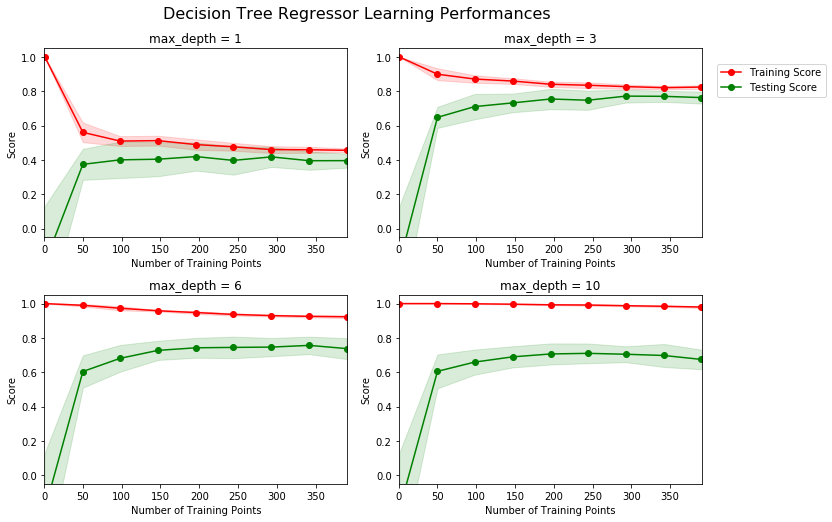

In [7]:
# Produce learning curves for varying training set sizes and maximum depths
vs.ModelLearning(features, prices)

<br>
    Model with <b>max_depth = 3.</b></li>
<ul>
  <li>Initially, as more training points are added, the score of the training curve decreases while that of the testing curve increases. </li>
  <li>Adding more training points to this model decrease the gap between training and testing scores. But as can be seen, in this case, that after the number of training points reach ~300, the scores of both the curves are converging (gap between training and testing scores is almost constant) to a certain value (threshold). </li>
  <li>Also the uncertainty is minimum after the model hits this threshold.</li>
  <li>Hence the model will not benefit by adding more points after that. If we keep adding more trainining points after reaching the threshold, we will be making the analysis computationally expensive with no additional benefits, and therefore should be avoided.</li>
</ul>

### Complexity Curves
The following code cell produces a graph for a decision tree model that has been trained and validated on the training data using different maximum depths. The graph produces two complexity curves — one for training and one for validation. Similar to the **learning curves**, the shaded regions of both the complexity curves denote the uncertainty in those curves, and the model is scored on both the training and validation sets using the `performance_metric` function.  

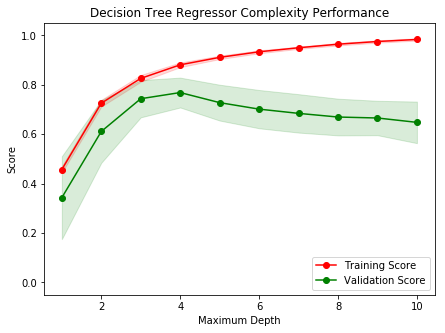

In [8]:
vs.ModelComplexity(X_train, y_train)

### Bias-Variance Tradeoff

<ol>
 <li>When the model is trained with a <b>max_depth = 1</b>,
  <ul>
   <li>The scores are similar for training and validation set (gap between the two curves is smaller). </li>
   <li>But the overall score is still small implying that the errors are large and model is not complex enough to pick up the nuances in the data which is a sign of underfitting. </li>
   <li>This indicates that it suffers from <b>high bias</b>.</li>
   </ul>
 </li>
 <li>When the model is trained with a <b>max_depth = 10</b>,
  <ul>
   <li>In this case, the overall score is higher (errors are smaller) but the two curves are well separated. </li>
   <li>A high score for the training set implies that the model is working well on the training data but is not able to generalize the data well which is sign of overfitting.  </li>
   <li>Also, it can be noted that the uncertainty in the validation set is larger for maximum depth of 10 as              compared to that at 4. Hence at a maximum depth of 10, the model is suffering from <b>high variance</b>. </li>
   </ul>
 </li>  
</ol>

Based on the graphs, I think <b>max_depth = 4</b> results in a model that best generalizes the unseen data. Maximum depth of 3 and 4 both have sort of high validation score while it is highest at a depth of 4. After this point, the separation between the two curves begins to increase (scores are diverging). Also, the uncertainty in the validation score is smaller for depth of 4 than compared to 3.

-----

## Evaluating Model Performance
In this final section of the project, we will construct a model and make a prediction on the client's feature set using an optimized model from `fit_model`.

### Grid Search

<ul>
  <li>The grid search technique is used to tune a set of parameters of an algorithm when training a model. The grid is just a table of parameters that need to be tuned. The end goal of this method is to pick the best combination of parameters that gives the best fit model for our dataset (which maximizes performance score), therefore optimizing a learning algorithm. </li>
  <li>For example, if we are training a model using Support Vector Machine algorithm then there are a number of parameters (kernels, gamma, C etc) that can be adjusted to get a optimal values of each. </li>
  <li>Kernels can be set to linear, polynomial, rbf etc while different values of gamma can make a decision boundary smoother or complex. A grid search will make a table for these parameters. So in this example, we will have columns for kernels and rows for different values of gamma. </li>
  <li>We use training data to train the model for each combination of kernel and gamma. And then we pick the best combination that fits well on the testing data meaning which gives highest performance score. </li>
</ul>

### Cross-Validation

<ol>
  <li><b>k-fold cross validation:</b>
   <ul>
    <li>In this method, we break our data randomly into equal k subsets (folds). Out of these k subsets, a single subset is chosen to be our cross validation set and the remaining k-1 subsets are used as our training set.  </li>
    <li>The training set is used to train the parameters. The cross validation set is used to make decisions about the model.</li>
    <li>This process is repeated k times, everytime splitting the data into k subsets randomly .</li>
    <li> The k results are then averaged to get a final score.</li>
   </ul>
  </li>
  <li><b>Benefits of k-fold cross validation for grid search method:</b>
   <ul>
    <li>The main drawback of using grid search on training and testing set is when a dataset is split into training and testing subsets, we are throwing away some data into the testing set that could be useful for training our algorithm. K-fold cross validation training technique can help alleviate this issue.  </li>
    <li>For the same example in Question 7, we can use training data to train the model for each combination of kernel and gamma. Then we compute some metric (for example, f1 score) and calculate it on the cross-validation set for each combination. Then we pick a combination that gives highest f1 score. Then we train our model k times and average the results to finally test it on the testing set to make sure that the model is good. </li>
   </ul>
  </li>
</ol>

### Fitting a Model
Our final implementation requires to bring everything together and train a model using the **decision tree algorithm**. To ensure that we are producing an optimized model, we will train the model using the grid search technique to optimize the `'max_depth'` parameter for the decision tree. The `'max_depth'` parameter can be thought of as how many questions the decision tree algorithm is allowed to ask about the data before making a prediction. Decision trees are part of a class of algorithms called *supervised learning algorithms*.

In addition, we will find your implementation is using `ShuffleSplit()` for an alternative form of cross-validation (see the `'cv_sets'` variable). The `ShuffleSplit()` implementation below will create 10 (`'n_splits'`) shuffled sets, and for each shuffle, 20% (`'test_size'`) of the data will be used as the *validation set*. 

In [9]:
# TODO: Import 'make_scorer', 'DecisionTreeRegressor', and 'GridSearchCV'
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import ShuffleSplit

def fit_model(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    # sklearn version 0.18: ShuffleSplit(n_splits=10, test_size=0.1, train_size=None, random_state=None)
    # sklearn versiin 0.17: ShuffleSplit(n, n_iter=10, test_size=0.1, train_size=None, random_state=None)
    cv_sets = ShuffleSplit(n_splits=10, test_size = 0.20, random_state=None)

    # TODO: Create a decision tree regressor object
    regressor = DecisionTreeRegressor()

    # TODO: Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {'max_depth':range(1,11)}

    # TODO: Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)

    # TODO: Create the grid search cv object --> GridSearchCV()
    # Make sure to include the right parameters in the object:
    # (estimator, param_grid, scoring, cv) which have values 'regressor', 'params', 'scoring_fnc', and 'cv_sets' respectively.
    grid = GridSearchCV(regressor, params, scoring = scoring_fnc, cv = cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

### Making Predictions
Once a model has been trained on a given set of data, it can now be used to make predictions on new sets of input data. In the case of a *decision tree regressor*, the model has learned *what the best questions to ask about the input data are*, and can respond with a prediction for the **target variable**. 

### Optimal Model

In [11]:
# Fit the training data to the model using grid search
reg = fit_model(X_train, y_train)

# Produce the value for 'max_depth'
print "Parameter 'max_depth' is {} for the optimal model.".format(reg.get_params()['max_depth'])

Parameter 'max_depth' is 3 for the optimal model.


The optimal model has a maximum depth of 4. This results agrees well with my guess in Question 6.

### Predicting Selling Prices
Imagine that you were a real estate agent in the Boston area looking to use this model to help price homes owned by your clients that they wish to sell. You have collected the following information from three of your clients:

| Feature | Client 1 | Client 2 | Client 3 |
| :---: | :---: | :---: | :---: |
| Total number of rooms in home | 5 rooms | 4 rooms | 8 rooms |
| Neighborhood poverty level (as %) | 17% | 32% | 3% |
| Student-teacher ratio of nearby schools | 15-to-1 | 22-to-1 | 12-to-1 |

Let's see what prices our trained model will predict for these clients, and if they seem reasonable given the features.

In [12]:
# Produce a matrix for client data
client_data = [[5, 17, 15],  # Client 1
              [4, 32, 22],   # Client 2         
              [8, 3, 12]]    # Client 3

# Show predictions
for i, price in enumerate(reg.predict(client_data)):
    print "Predicted selling price for Client {}'s home: ${:,.2f}".format(i+1, price)

Predicted selling price for Client 1's home: $397,740.00
Predicted selling price for Client 2's home: $283,455.79
Predicted selling price for Client 3's home: $913,350.00


In [13]:
# Show the calculated statistics
print "Statistics for Boston housing dataset:\n"
print "Minimum price: ${:,.2f}".format(minimum_price)
print "Maximum price: ${:,.2f}".format(maximum_price)
print "Mean price: ${:,.2f}".format(mean_price)
print "Median price ${:,.2f}".format(median_price)
print "Standard deviation of prices: ${:,.2f}".format(std_price)

Statistics for Boston housing dataset:

Minimum price: $105,000.00
Maximum price: $1,024,800.00
Mean price: $454,342.94
Median price $438,900.00
Standard deviation of prices: $165,171.13


<ol>
 <li>Recommended selling prices are:
  <ul>
   <li>Client 1's home: &#36;415,887.50</li>
   <li>Client 2's home: &#36;233,539.53</li>
   <li>Client 3's home: &#36;896,962.50</li>
  </ul>
 </li>
 <li>Based on guess from Question 1:
  <ul>
   <li>Client 2 has least number of rooms (directly proportional to price), highest percentage of low income population (inversely proportional to price) and highest student to teacher ratio (inversely proportional to price).</li> 
   <li>So based on the guess in Question 1, client 2 should have lowest selling price. And client 1's home should have highest selling price. Client 2's home price &lt; client 1's home price &lt; client 3's home price. This is in agreement with the recommended selling prices. </li>
  </ul>
  <li>Based on the statistics from Data Exploration section:
  <ul>
   <li>We notice that the recommended prices are within the range of prices of the existing houses. </li>
  </ul>
</ol>

### Sensitivity
An optimal model is not necessarily a robust model. Sometimes, a model is either too complex or too simple to sufficiently generalize to new data. Sometimes, a model could use a learning algorithm that is not appropriate for the structure of the data given. Other times, the data itself could be too noisy or contain too few samples to allow a model to adequately capture the target variable — i.e., the model is underfitted. 

### Applicability

Now let's discuss whether the constructed model should or should not be used in a real-world setting.  

<ol>
 <li>House prices vary a lot every few years so the data that was collected in 1978 is not completely relevant today. Although we need this data, we also need data from recent years to account for inflation. </li>
 <li>The features presented in the data are not sufficient to describe a home. Factors like square feet of the plot area, presence of pool, how old the house is, crime rate in the neighborhood, if public transport, groceries, hospital etc is available nearby or not, could all be useful for a better model.</li>
 <li>The model is not robust enough to make consistent predictions as can be seen from the sensitivity calculation. The range in prices is quite high, even comparable to individual annual salaries. </li>
 <li>I don't think that the data collected in an urban city like Boston should be applicable in a rural city as there will be different factors responsible in determining the price of the house in a rural area.</li>
 <li>Although we can estimate range of house price based on the characteristics of the entire neighborhood, it is not fair to judge the price of an individual house. This model is okay if we use it to predict a range of price for a house. But additional factors such as those mentioned above should be used to predict actual price of a house.</li>
 <li>Overall, the predictions based on this model should not be used in a real-world setting.</li> 
</ol>